## Midterm - MNIST Classification with Adam
### Shailesh Patro

I have implemented an Adam optimizer based on *ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION* by Diederik P. Kingma & Jimmy Lei Ba         
(https://arxiv.org/pdf/1412.6980v8.pdf). 
The implementation uses Keras base class and common methods for compatbility with a keras model. The keras compatibility is preferable for testing the optimizer quickly on several datasets.

I have tested the optimizer on three data sets:

1.   Sine Curve Regression
2.   MNIST Classification
3.   AG News data Classification



In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


from keras.optimizers import Optimizer



In [9]:

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
class AdamOptimizer(Optimizer):
  def __init__(self, alpha=0.001, beta_1=0.9,
               beta_2=0.999, epsilon=1e-08, 
               **kwargs):
    super(AdamOptimizer, self).__init__(**kwargs)
    with keras.backend.name_scope(self.__class__.__name__):
      self.iterations = keras.backend.variable(0, dtype='int64', name='iterations')
      # alpha is the stepsize/learning rate as described in the paper
      self.alpha = keras.backend.variable(alpha, name='alpha')
      # beta_1, beta_2 are the exponential decay rates for the moment estimates
      self.beta_1 = keras.backend.variable(beta_1, name='beta_1')
      self.beta_2 = keras.backend.variable(beta_2, name='beta_2')
      self.epsilon = epsilon
 


  def get_updates(self, loss, params):
    xs = params
    # get gradients with tensorflow's built in gradient function
    grads = tf.gradients(loss, xs, colocate_gradients_with_ops=True)
    self.updates = [tf.assign_add(self.iterations, 1)]
    # alpha is the learning rate as defined in the paper
    alpha = self.alpha
    # increment timestep by 1
    t = tf.cast(self.iterations, 'float32') + 1
    
    # suggested improvement as mentioned in section 2: algorithm
    alpha_t = alpha * (tf.sqrt(1. - tf.pow(self.beta_2, t)) / (1. - tf.pow(self.beta_1, t))) 
    
    # initialize m, v to zero
    ms = [keras.backend.zeros(x.shape, dtype=x.dtype.base_dtype.name) for x in xs]
    vs = [keras.backend.zeros(x.shape, dtype=x.dtype.base_dtype.name) for x in xs]
 
    self.weights = [self.iterations] + ms + vs
    
    for x, g, m, v in zip(xs, grads, ms, vs):
        # Update biased first moment estimate
        m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
        
        # Update biased second raw moment estimate 
        # also used tensorflow's elementwise square
        v_t = (self.beta_2 * v) + (1. - self.beta_2) * tf.square(g) 
        
        # Update Parameters
        x_t = x - alpha_t * m_t / (tf.sqrt(v_t) + self.epsilon)
        self.updates.append(tf.assign(m, m_t))
        self.updates.append(tf.assign(v, v_t))
        new_x = x_t

        self.updates.append(tf.assign(x, new_x))
    return self.updates

  
  
  def get_config(self):
    config = {'alpha': float(keras.backend.get_value(self.alpha)),
              'beta_1': float(keras.backend.get_value(self.beta_1)),
              'beta_2': float(keras.backend.get_value(self.beta_2)),
              'epsilon': self.epsilon}
    base_config = super(AdamOptimizer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))
  

In [0]:
class LearningRateCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.alphavals = []
 
  def on_batch_end(self, batch, logs=None):
    alpha = self.model.optimizer.alpha
    iterations = self.model.optimizer.iterations
    beta_2 = self.model.optimizer.beta_2
    beta_1 = self.model.optimizer.beta_1
    t = tf.cast(iterations, 'float32') + 1
    alpha_t = alpha * (tf.sqrt(1. - tf.pow(beta_2, t)) / (1. - tf.pow(beta_1, t)))
    self.alphavals.append(keras.backend.eval(alpha_t))

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
adamopt = AdamOptimizer()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adamopt,
              metrics=['accuracy'])
history = keras.callbacks.History()
lr = LearningRateCallback()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[history, lr]);

Test loss: 0.028430828821798787
Test accuracy: 0.9893


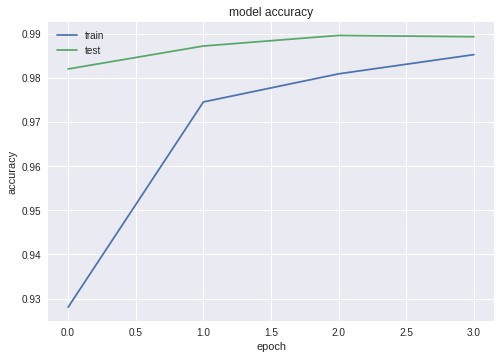

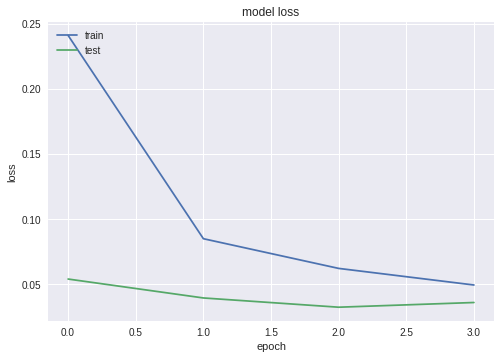

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

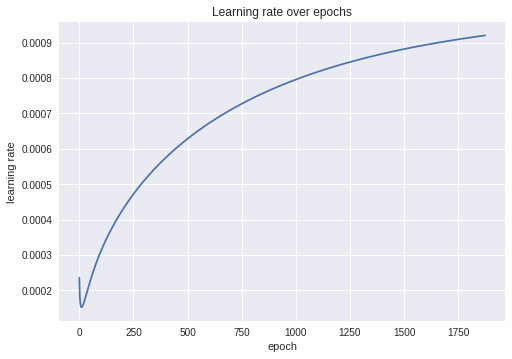

In [13]:
plt.plot(lr.alphavals)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.title('Learning rate over epochs');

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
adamopt = AdamOptimizer()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adamopt,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 12s 196us/step - loss: 0.2435 - acc: 0.9266 - val_loss: 0.0534 - val_acc: 0.9818
Epoch 2/4
60000/60000 [==============================] - 9s 154us/step - loss: 0.0867 - acc: 0.9744 - val_loss: 0.0369 - val_acc: 0.9885
Epoch 3/4
60000/60000 [==============================] - 9s 157us/step - loss: 0.0635 - acc: 0.9811 - val_loss: 0.0338 - val_acc: 0.9894
Epoch 4/4
60000/60000 [==============================] - 9s 156us/step - loss: 0.0533 - acc: 0.9834 - val_loss: 0.0284 - val_acc: 0.9893
Test loss: 0.028430828821798787
Test accuracy: 0.9893
